## Setup

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

import os.path as osp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Graph

In [2]:
BASE_DIR = "/Users/giacomoorsi/DocsNotSynced/EPFL/Dataset/Twitter/"

In [3]:
G = nx.read_graphml(osp.join(BASE_DIR, "users_clean.graphml"))

In [4]:
# Print descriptive statistics such as number of nodes, edges, etc.
print(
    f"The graph contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
)

The graph contains 100386 nodes and 2286592 edges.


## Node attributes

In [6]:
df = pd.read_csv(osp.join(BASE_DIR, "users_neighborhood_anon.csv"), index_col=0)

In [11]:
# remove user_id from index and add it as a column
df.reset_index(inplace=True)

For a description of features see https://www.kaggle.com/datasets/manoelribeiro/hateful-users-on-twitter

We only keep the features that represent attributes from the Twitter profile and from the text of the tweets, i.e. we remove the features that can be computed from the graph. Specifically, we do not consired the features aggregated from neighbors, since we will use Graph Machine Learning methods that, hopefully, extract the same kind of information in better ways. We also do not consider the features that are computed from the graph structure, such as centrality measures, since we will extract them ourselves later.

In [12]:
columns = list(df.columns)

features = [
    "user_id",
    "hate",
    # "hate_neigh",
    # "normal_neigh",
    "statuses_count",
    "followers_count",
    "followees_count",
    "favorites_count",
    "listed_count",
    # "betweenness",
    # "eigenvector",
    # "in_degree",
    # "out_degree",
    "sentiment",
    "subjectivity",
    "number hashtags",
    # "hashtags",
    "tweet number",
    "retweet number",
    "quote number",
    "status length",
    "number urls",
    "baddies",
    "mentions",
    # "is_50",
    # "is_63",
    # "is_50_2",
    # "is_63_2",
    "time_diff",
    "time_diff_median",
    "created_at",
]

features += list(
    filter(lambda x: x.endswith("_empath") and not x.startswith("c_"), columns)
)
features += list(
    filter(lambda x: x.endswith("_glove") and not x.startswith("c_"), columns)
)

In [13]:
df

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100381,100381,other,False,False,6425,70081,551,1770,223,91339.873881,...,0.000306,0.005301,0.000867,0.001511,0.000867,0.002858,0.011876,0.003625,0.001255,0.005197
100382,100382,other,False,True,16928,62727,463,52132,100,68208.504656,...,0.000387,0.003703,0.000586,0.002220,0.000872,0.005985,0.007646,0.002230,0.002274,0.009827
100383,100383,other,False,False,1118,12885,29,0,598,80904.560366,...,0.000229,0.003623,0.000946,0.002061,0.001571,0.002724,0.019474,0.003187,0.001069,0.005130
100384,100384,other,False,False,3359,517,137,595,17,37072.184175,...,0.001800,0.002066,0.000414,0.001858,0.000242,0.003691,0.005644,0.000885,0.001152,0.005624


In [14]:
df = df[features]
df

,user_id,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,sentiment,subjectivity,number hashtags,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,0,normal,101767,3504,3673,81635,53,0.035132,0.431656,16.0,...,-0.162803,0.022277,-0.061740,-0.108736,0.095297,0.014048,-0.079171,-0.064034,0.039573,0.121562
1,1,other,2352,19609,309,61,197,0.088142,0.418649,40.0,...,-0.220041,0.061212,0.045925,-0.090857,0.033579,-0.038353,-0.068932,-0.076778,0.016700,0.081580
2,2,other,1044,2371,2246,561,16,0.117861,0.455828,328.0,...,-0.071102,0.044288,0.044124,-0.058129,-0.026722,-0.034385,-0.015848,-0.033579,-0.015725,0.110611
3,3,other,167172,3004,298,3242,53,0.261688,0.558544,127.0,...,-0.085447,0.039014,0.014094,-0.090334,0.155788,-0.006964,-0.071013,-0.043521,0.023655,0.126403
4,4,other,1998,17643,19355,485,239,0.121533,0.435334,1710.0,...,-0.162940,0.112401,-0.109144,-0.143494,-0.015770,0.184437,0.015669,0.074143,-0.107558,-0.102976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100381,100381,other,6425,70081,551,1770,223,0.174331,0.511019,241.0,...,-0.101585,0.056177,-0.011879,-0.079700,0.057477,-0.037915,-0.044164,-0.029799,-0.056733,0.108609
100382,100382,other,16928,62727,463,52132,100,0.227946,0.571372,69.0,...,-0.048893,-0.034731,-0.102936,-0.107279,0.135280,-0.022714,-0.062393,-0.037941,-0.016274,0.070525
100383,100383,other,1118,12885,29,0,598,0.182165,0.446904,143.0,...,-0.139124,0.025163,0.048279,-0.062656,0.027198,-0.054500,-0.013992,-0.046172,-0.037651,0.112789
100384,100384,other,3359,517,137,595,17,0.116135,0.541092,97.0,...,-0.140663,0.020672,-0.031872,-0.104729,0.103883,-0.035841,-0.071515,-0.048701,0.055673,0.084698


In [15]:
df.hate.value_counts()

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64

# 1. Preliminary exploration
In this section, we carry out some exploratory analysis of the dataset. 
We will have a look at: 
1. The degree distribution of the graph
2. Connectivity of the graph
3. Distribution of graphlets
4. The distribution of the labels
5. The distribution of the features
6. The correlation between features and labels


In [16]:
# plot the degree distribution of the graph

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [17]:
degrees = [G.degree(n) for n in G.nodes()]

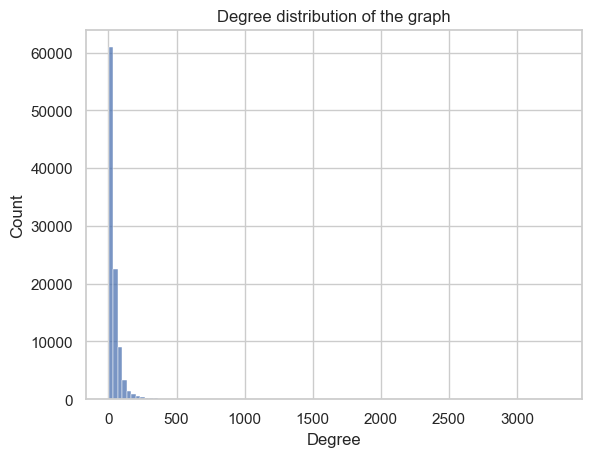

In [19]:
sns.histplot(degrees,  bins=100)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution of the graph")
plt.show()

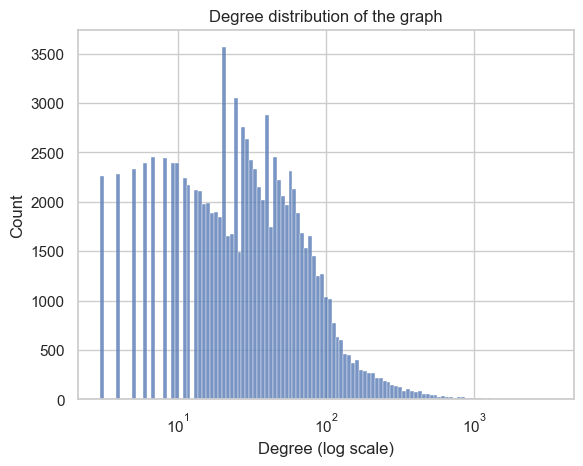

In [20]:
sns.histplot(degrees, log_scale=True)
plt.xlabel("Degree (log scale)")
plt.ylabel("Count")
plt.title("Degree distribution of the graph")
plt.show()

We can consider the graph as undirected and check the connected components

In [23]:
# connected components
G_undirected = G.to_undirected()
cc = list(nx.connected_components(G_undirected))
cc = sorted(cc, key=len, reverse=True)
print(f"The graph has {len(cc)} connected components.")

The graph has 1 connected components.


##### 3. Distribution of the graphlets

##### 4. Distribution of the features

In [35]:
print(features)

['user_id', 'hate', 'statuses_count', 'followers_count', 'followees_count', 'favorites_count', 'listed_count', 'sentiment', 'subjectivity', 'number hashtags', 'tweet number', 'retweet number', 'quote number', 'status length', 'number urls', 'baddies', 'mentions', 'time_diff', 'time_diff_median', 'created_at', 'negotiate_empath', 'vehicle_empath', 'science_empath', 'timidity_empath', 'gain_empath', 'swearing_terms_empath', 'office_empath', 'tourism_empath', 'computer_empath', 'violence_empath', 'horror_empath', 'dispute_empath', 'sadness_empath', 'internet_empath', 'college_empath', 'attractive_empath', 'plant_empath', 'technology_empath', 'reading_empath', 'deception_empath', 'ancient_empath', 'ship_empath', 'messaging_empath', 'surprise_empath', 'occupation_empath', 'hearing_empath', 'furniture_empath', 'restaurant_empath', 'domestic_work_empath', 'art_empath', 'pet_empath', 'air_travel_empath', 'dance_empath', 'healing_empath', 'smell_empath', 'sympathy_empath', 'anger_empath', 'negl

In [36]:
features_analyzed = ['hate', 'statuses_count', 'followers_count', 'followees_count', 'favorites_count', 'listed_count', 'sentiment', 'subjectivity',  'tweet number', 'retweet number', 'quote number', 'status length', 'baddies', 'mentions']

In [39]:
df[features_analyzed].describe()

,statuses_count,followers_count,followees_count,favorites_count,listed_count,sentiment,subjectivity,tweet number,retweet number,quote number,status length,baddies,mentions
count,1.003860e+05,1.003860e+05,1.003860e+05,1.003860e+05,100386.000000,100009.000000,100009.000000,100009.000000,100009.00000,100009.000000,100009.000000,100009.000000,100009.000000
mean,2.788436e+04,1.131832e+05,2.891717e+03,1.279354e+04,534.857789,0.133680,0.502814,122.751612,72.11093,16.060975,108.729326,21.629353,150.361048
std,6.325047e+04,1.300094e+06,2.097654e+04,3.255763e+04,3742.277767,0.086279,0.066993,52.832745,51.51704,18.919533,30.925540,18.214057,182.703546
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000
25%,2.436000e+03,7.820000e+02,3.000000e+02,5.660000e+02,10.000000,0.073995,0.466946,84.000000,29.00000,2.000000,85.120000,10.000000,65.000000
50%,9.102000e+03,2.947000e+03,7.070000e+02,2.736500e+03,56.000000,0.121134,0.507132,130.000000,65.00000,10.000000,111.320000,17.000000,125.000000
75%,2.885200e+04,1.437475e+04,1.581000e+03,1.087200e+04,245.000000,0.183746,0.543520,167.000000,109.00000,23.000000,130.705000,28.000000,199.000000
max,7.756870e+06,1.055672e+08,3.078587e+06,1.030071e+06,615331.000000,1.000000,1.000000,200.000000,200.00000,199.000000,912.330000,568.000000,11657.000000


In [60]:
df[feature].value_counts()

26         65
55         61
9          59
89         58
46         57
           ..
1987138     1
269755      1
1664416     1
29256       1
62727       1
Name: followers_count, Length: 34726, dtype: int64

As the graph is very big, we take a random sample of 10% to perform our analysis

In [71]:
df_sample = df.sample(1000)

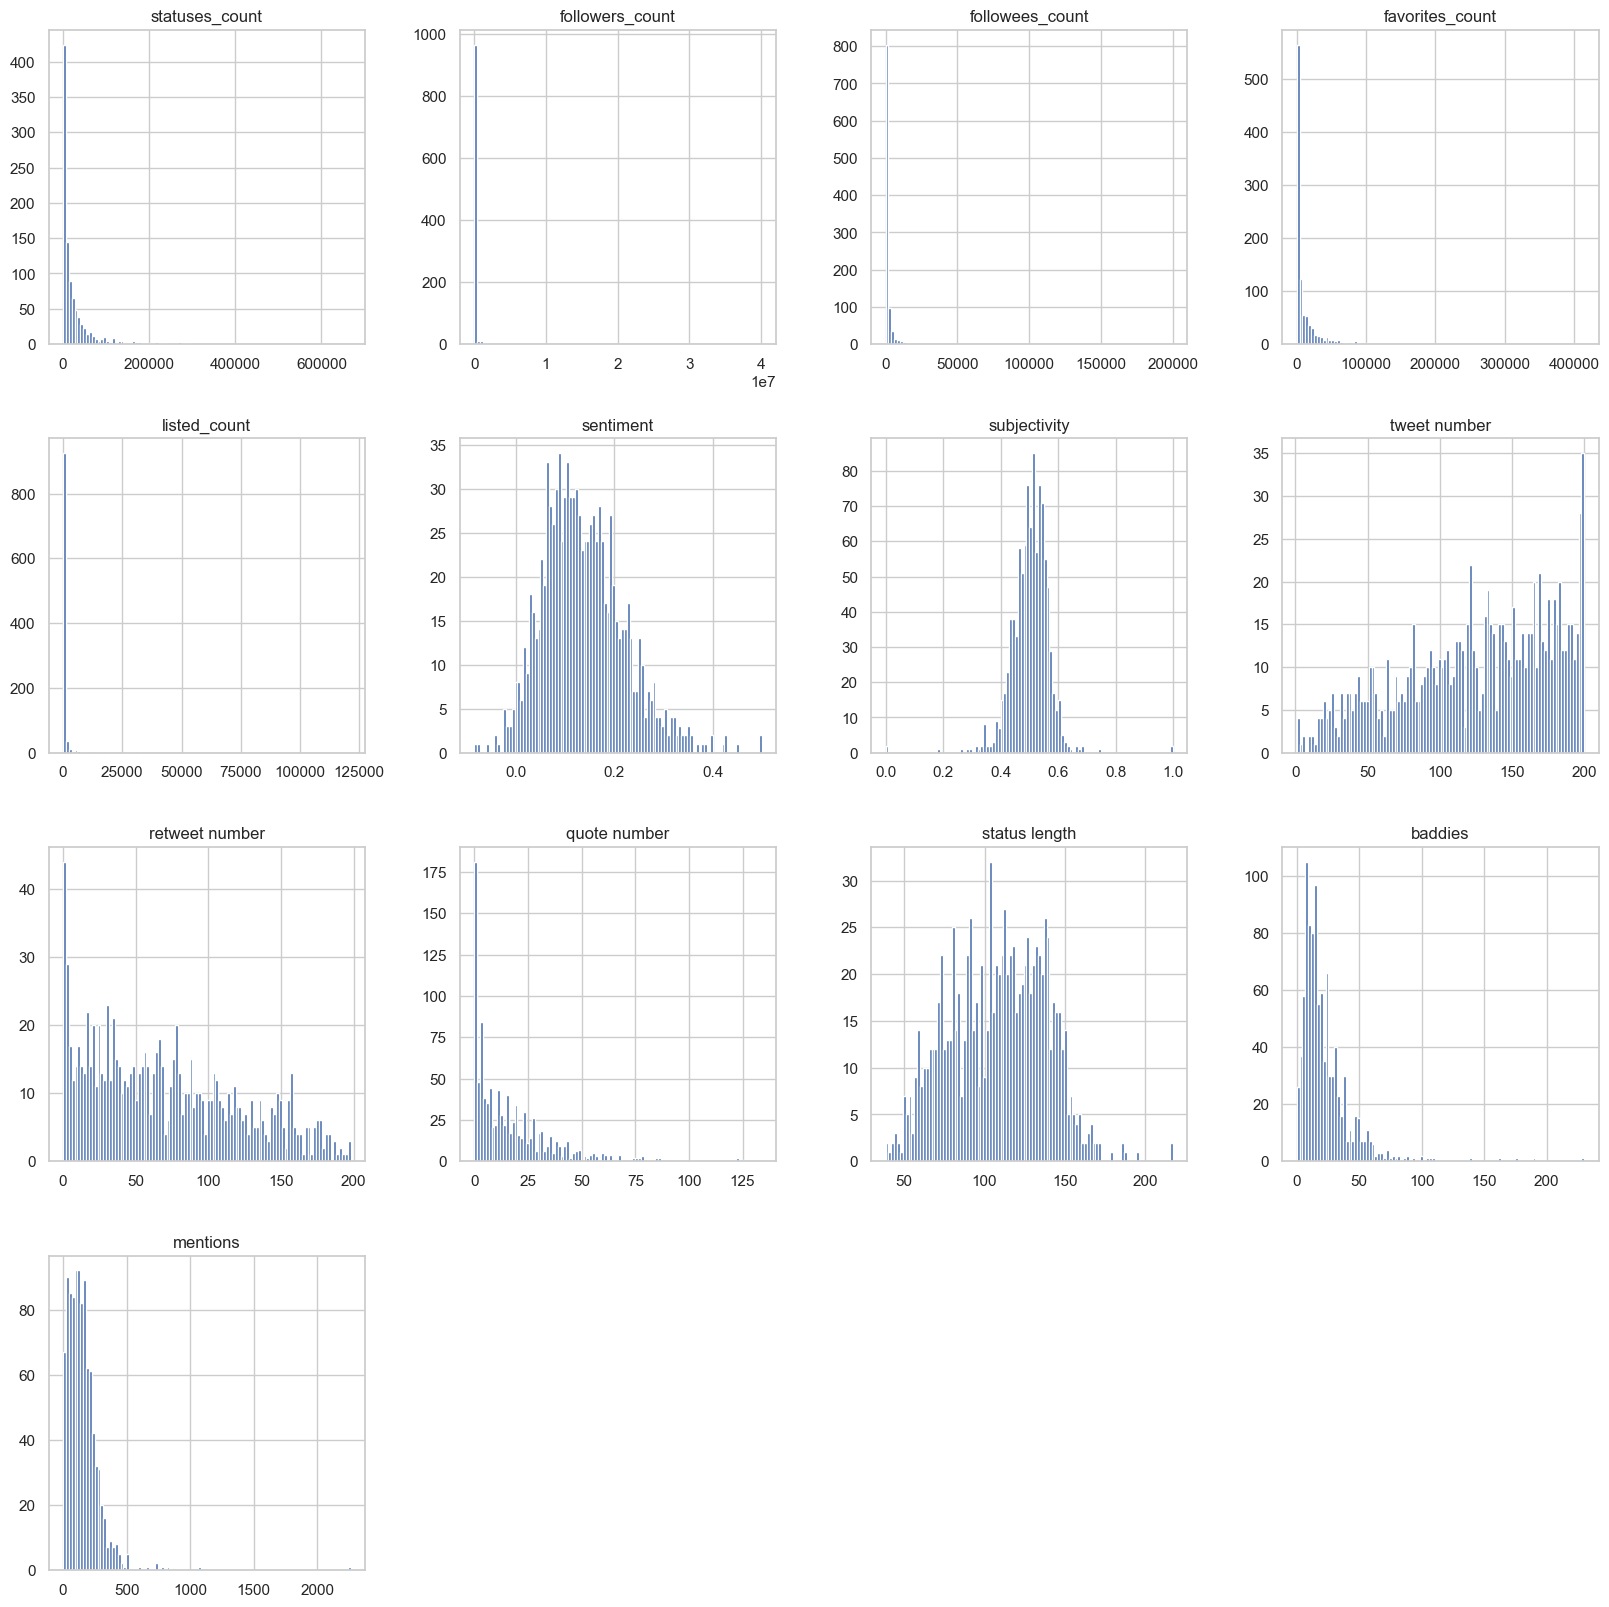

In [77]:
# plot distribution of all features using pandas
df_sample[features_analyzed].hist(bins=100, figsize=(20, 20))
plt.show()


From a first look at the features, we can see that the dataset includes accounts with a limited number of followers, so that don't belong to celebrities or influencers. 

Let's have a look at the label distribution

In [81]:
counts = df["hate"].value_counts()
print(counts)

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


The number of hateful users is very limited as compared to the number of non-hateful users. This is a typical case of imbalanced dataset. We will have to take this into account when training our models.

In [85]:
print("Hateful users are {}% of the total, normal users are {}% and unknown users are {}%.".format(round(counts["hateful"]/df.shape[0]*100, 2), round(counts["normal"]/df.shape[0]*100, 2), round(counts["other"]/df.shape[0]*100, 2)))

Hateful users are 0.54% of the total, normal users are 4.41% and unknown users are 95.05%.


# 2. Network models
We simulate the network using different network models and compare the results with the real network. We use the following network models:
1. Erdos-Renyi
2. Watts-Strogatz
3. Barabasi-Albert


Let's simulate a network using different models to see which one approximates better the real network

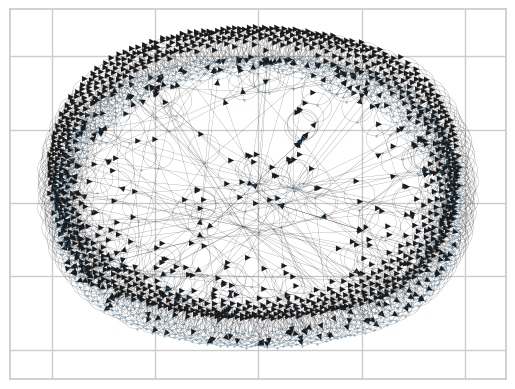

In [96]:
# take a sample of the graph 
nodes_sample = np.random.choice(G.nodes(), 1000, replace=False)
G_sample = G.subgraph(nodes_sample)
nx.draw_networkx(G_sample, with_labels=False, node_size=0.1, width=0.1)

In [98]:
average_clustering_coeffient = nx.average_clustering(G)

In [100]:
print(average_clustering_coeffient)

0.05665756186782143


The average clustering coefficient is 0.056, which is a pretty low value. 

##### a. Configuration model
We fit a configuration model based on the degree distribution of the real network

In [103]:
degrees = [G.degree(n) for n in G.nodes()]

G_config = nx.configuration_model(degrees)

print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))
print('Original graph has {} nodes and {} edges.'.format(G.number_of_nodes(), G.size()))

Configuration model has 100386 nodes and 2286592 edges.
Original graph has 100386 nodes and 2286592 edges.


In [109]:
print('Number of self-loops in original graph: {}'. format(nx.number_of_selfloops(G)))

Number of self-loops in original graph: 100386


#### CHECK: why does each node has a self-loop??

In [104]:
print('Number of self-loops in configuration model: {}, Number of connected components in configuration model: {}'. format(nx.number_of_selfloops(G_config), nx.number_connected_components(G_config)))

Number of self-loops in configuration model: 88, Number of connected components in configuration model: 1


##### b. Watts-Strogatz model
We simulate a Watts-Strogatz model with the same number of nodes and average degree as the real network. 
The parameter $k$ is the average degree of the network, and we fit it to the average degree of the real network. As seen in the course, we fit the parameter $p$ to make this model have the same average clustering coefficient as the real network.

In [122]:
# TODO: for following tasks decide whether to use original graph or take a sample
# computations on the size of the original graph are very very expensive
# so we should choose a reasonable subgraph

# FIXME:
# Problem: if we sample a small subgraph, it is unlikely to be connected
# This means that it will actually not reproduce correctly the original graph

G_undirected = G_sample.to_undirected()


In [119]:
# Here we compute some statistics on the graph that we will need to fit Watts-Strogatz models. 

cc = nx.average_clustering(G_undirected)

# avg_shortest_path = nx.average_shortest_path_length(G_undirected)
# since it is not connected, we compute the average shortest path for each connected component and then average them
avg_shortest_path = 0
for component in nx.connected_components(G_undirected):
    avg_shortest_path += nx.average_shortest_path_length(G_undirected.subgraph(component)) * len(component)

avg_shortest_path /= G_undirected.number_of_nodes()

k = int(np.round(np.mean(degrees)))
n = len(G_undirected.nodes())

100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Scaled clustering coefficient of citation graph: 0.005507575757575699
Scaled average shortest path length of citation graph: 0.10711245496233214


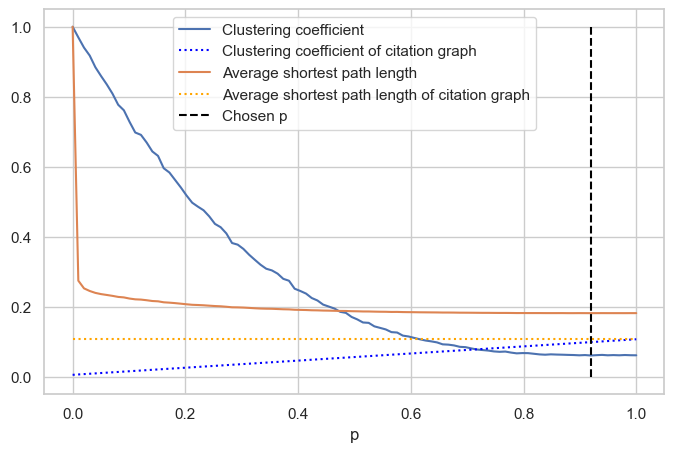

Optimal value of p: 0.9191919191919192
Scaled clustering coefficient difference at p_opt: 0.055220506473054175
Scaled average shortest path length difference at p_opt: 0.07457535335338315


In [121]:
probs = np.linspace(0, 1, 100)
ccs = []
ds = []
for p in tqdm(probs):
    G = nx.watts_strogatz_graph(n, k, p)
    ccs.append(nx.average_clustering(G))
    ds.append(nx.average_shortest_path_length(G))

G_p0 = nx.watts_strogatz_graph(n, k, 0)
cc_0 = nx.average_clustering(G_p0)
d_0 = nx.average_shortest_path_length(G_p0)

ccs = [x / cc_0 for x in ccs]
ds = [x / d_0 for x in ds]



cc_scaled = cc / cc_0
d_scaled = avg_shortest_path / d_0

print('Scaled clustering coefficient of citation graph:', cc_scaled)
print('Scaled average shortest path length of citation graph:', d_scaled)

# we plot the two values on the same plot
plt.figure(figsize=(8, 5))
plt.plot(probs, ccs, label='Clustering coefficient')
plt.plot([0, 1], [cc_scaled, d_scaled], label='Clustering coefficient of citation graph', linestyle='dotted', color="blue")
plt.plot(probs, ds, label='Average shortest path length')
plt.plot([0, 1], [d_scaled, d_scaled], label='Average shortest path length of citation graph', linestyle='dotted', color="orange")
plt.xlabel('p')

# we choose the value of p that minimizes the difference between the scaled CC for the citation graph with the
# scaled CC for the WS graph at p and the scaled average shortest path length for the citation graph with the
# scaled average shortest path length for the WS graph at p

differences = []
for i in range(len(probs)):
    differences.append(abs(cc_scaled - ccs[i]) + abs(d_scaled - ds[i]))

p_opt = probs[np.argmin(differences)]

# add a vertical line to the plot to show the optimal value of p
plt.plot([p_opt, p_opt], [0,1], linestyle='dashed', label="Chosen p", color="black")
plt.legend()
plt.show()

print('Optimal value of p:', p_opt)
print('Scaled clustering coefficient difference at p_opt:', abs(cc_scaled - ccs[np.argmin(differences)]))
print('Scaled average shortest path length difference at p_opt:', abs(d_scaled - ds[np.argmin(differences)]))

G_ws = nx.watts_strogatz_graph(n, k, p_opt, seed=42)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^